In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
import random
import matplotlib.pyplot as plt
import pandas as pd

import time

from model_training_ck.models import MobileNetV3, ViT
from model_training_ck.trainer import count_nonzero_parameters


/home/diogoalves/thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_directory = "model_training_ck/models"
data_directory = "ck_data"

In [3]:

def load_models(model_directory):
    models = {}
    for model_name in os.listdir(model_directory):
        if model_name.endswith('.pt') or model_name.endswith('.pth'):
            print(model_name)

            if "vit" in model_name.lower():
                model = ViT(num_labels=7)
                model.load_state_dict(torch.load(model_directory+"/"+model_name))
            else:
                model = MobileNetV3(num_labels=7)
                model.load_state_dict(torch.load(model_directory+"/"+model_name))
            models[model_name] = model.to('cpu')
    return models

def calculate_inference_time(model, input_tensor, repetitions=100):
    model.eval()
    input_tensor = input_tensor.to('cpu')
    with torch.no_grad():
        _ = model(input_tensor)

    start_time = time.time()
    with torch.no_grad():
        for _ in range(repetitions):
            _ = model(input_tensor)
    end_time = time.time()

    average_inference_time = (end_time - start_time) / repetitions * 1000
    return average_inference_time

def load_images_with_labels(directory):
    images_with_labels = []

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = filename.split('.')[0]

            path = os.path.join(directory, filename)
            image = Image.open(path).convert('RGB')

            input_tensor = preprocess(image).unsqueeze(0)

            images_with_labels.append((input_tensor, label))

    return images_with_labels

def plot_images_with_labels(image_tensor_label_list):
    """
    Plots images from preprocessed tensors along with their corresponding labels.

    Parameters:
    - image_tensor_label_list: A list of tuples, where each tuple contains a preprocessed image tensor and its corresponding label.
    """
    num_images = len(image_tensor_label_list)
    plt.figure(figsize=(15, 15))

    for i, (input_tensor, label) in enumerate(image_tensor_label_list):
        image = input_tensor.squeeze(0).permute(1, 2, 0).numpy()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

    plt.show()


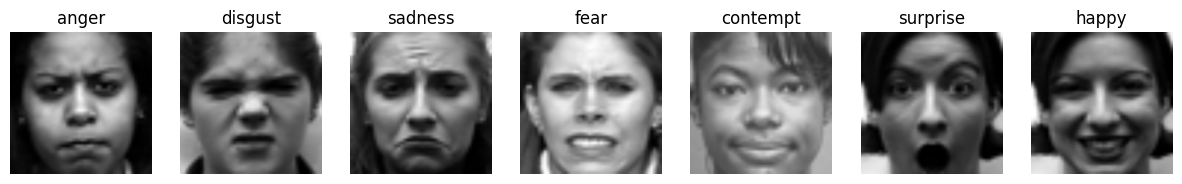

In [4]:

images_with_labels = load_images_with_labels(data_directory)

plot_images_with_labels(images_with_labels)

In [5]:
models = load_models(model_directory)

student.pt
distilled_lottery_ticket_590k.pt
mobilenetv3.pt
vit.pt


/home/diogoalves/thesis/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/diogoalves/thesis/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1836677/4190035962.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorc

lottery_ticket_900k.pt


In [6]:
nonzero_params_data = {'Model Name': [], 'Non-Zero Parameters': []}

for model_name, model in models.items():
    nonzero_params = count_nonzero_parameters(model)
    nonzero_params_data['Model Name'].append(model_name)
    nonzero_params_data['Non-Zero Parameters'].append(nonzero_params)

nonzero_params_df = pd.DataFrame(nonzero_params_data)
nonzero_params_df = nonzero_params_df.sort_values('Non-Zero Parameters', ascending=True)
nonzero_params_df

,Model Name,Non-Zero Parameters
1,distilled_lottery_ticket_590k.pt,590669
4,lottery_ticket_900k.pt,897098
0,student.pt,1515056
2,mobilenetv3.pt,1515056
3,vit.pt,85549056


In [7]:
models = dict(sorted(models.items()))

In [8]:
inference_times = {'Model Name': [], 'Label': [], 'Inference Time (ms)': []}
for model_name, model in models.items():
    for input_tensor, label in images_with_labels:
        time_taken = calculate_inference_time(model, input_tensor)
        inference_times['Model Name'].append(model_name)
        inference_times['Label'].append(label)
        inference_times['Inference Time (ms)'].append(time_taken)

    average_time = sum(inference_times['Inference Time (ms)'][-len(images_with_labels):]) / len(images_with_labels)
    inference_times['Model Name'].append(model_name)
    inference_times['Label'].append('Average')
    inference_times['Inference Time (ms)'].append(average_time)

inference_times_df = pd.DataFrame(inference_times)

In [9]:
average_inference_times_df = inference_times_df[inference_times_df['Label'] == 'Average']
average_inference_times_df = average_inference_times_df.sort_values('Inference Time (ms)')
average_inference_times_df

,Model Name,Label,Inference Time (ms)
7,distilled_lottery_ticket_590k.pt,Average,6.639166
15,lottery_ticket_900k.pt,Average,7.502807
31,student.pt,Average,7.622695
23,mobilenetv3.pt,Average,7.640370
39,vit.pt,Average,111.811232


In [10]:
pd.set_option('display.max_rows', None)
inference_times_df

,Model Name,Label,Inference Time (ms)
0,distilled_lottery_ticket_590k.pt,anger,6.764684
1,distilled_lottery_ticket_590k.pt,disgust,6.030478
2,distilled_lottery_ticket_590k.pt,sadness,6.247277
3,distilled_lottery_ticket_590k.pt,fear,6.082702
4,distilled_lottery_ticket_590k.pt,contempt,6.532962
5,distilled_lottery_ticket_590k.pt,surprise,7.490346
6,distilled_lottery_ticket_590k.pt,happy,7.325711
7,distilled_lottery_ticket_590k.pt,Average,6.639166
8,lottery_ticket_900k.pt,anger,7.447166
9,lottery_ticket_900k.pt,disgust,7.653255
